# Required Imports and Constants

In [1]:
%matplotlib inline

import ast
import json
import os
import sys
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
from matplotlib import patches

from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

CONDITIONS = ["CTRL", "WTHN", "BTWN", "BOTH"]
TASKS = ["hiring", "movies"]


CTRL_PIDS = [
    "0jjk2LtlRwXu",
    "BDIPCGcOdllu",
    "fimUvwh9JPRU",
    "jHPt9jOOmoXM",
    "nyEXxPkdgP81",
    "WvfHfFBIfx6m",
    "YqgrTs5hzcsj"
]

WTHN_PIDS = [
    "6BSJnNllOaUQ", 
    "8wC3YK6TgqRm", 
    "db2aF23Z9hnH", 
    "F0xDdtLRrhtQ", 
    "nRJBgq4Tg2LG", 
    "YvLb2lkRiYyh"
]

BTWN_PIDS = [
    "38vsTr4jwSxV",
    "fHevN3Wo38TA",
    "iswbEgz7w3KE",
    "kdSlRblQt77j",
    "mYSzFPXnkOdd",
    "QEpQRLrqn7CX",
    "Tcrfm9xpHN59"
]

BOTH_PIDS = [
    "1w4I0l6f60JG", 
    "7UR5LIyKmQiz", 
    "C9pIAv6kBqr6", 
    "KK2JFLnabEl9", 
    "MjcBTpGzYCD9", 
    "TlJaxdq1DM23"
]

ALL_PIDS = {
    'CTRL': CTRL_PIDS,
    'WTHN': WTHN_PIDS,
    'BTWN': BTWN_PIDS,
    'BOTH': BOTH_PIDS,
}

# Count number of interactions between conditions

In [2]:
rows = []

for condition in CONDITIONS:
    PIDS = ALL_PIDS[condition]
    for pid in PIDS:
        basepath = os.path.join(condition, pid)  # basepath for PID
        df = pd.read_csv(os.path.join(basepath, "interactions.csv"))
        df = df[df['appMode'].isin(TASKS)].reset_index(drop=True)
        rows.append([pid, condition, len(df.index)])

df = pd.DataFrame(
    rows,
    columns=['PID', 'Condition', '# Interactions Performed']
)

print(df.groupby('Condition').describe())

          # Interactions Performed                                          \
                             count       mean       std   min    25%   50%   
Condition                                                                    
BOTH                           6.0  39.333333  1.751190  38.0  38.00  38.5   
BTWN                           7.0  40.142857  4.413184  38.0  38.00  38.0   
CTRL                           7.0  39.714286  2.497618  38.0  38.00  39.0   
WTHN                           6.0  40.166667  1.722401  38.0  39.25  40.0   

                        
             75%   max  
Condition               
BOTH       40.50  42.0  
BTWN       39.50  50.0  
CTRL       40.00  45.0  
WTHN       40.75  43.0  


# Trajectory of recommendations across tasks/conditions

=== ALL TASKS/CONDITIONS ===
columns    Round 1    Round 2  Round 3    Round 4    Round 5    Round 6
index                                                                  
# No     32.000000  40.000000    39.00  34.000000  35.000000  36.000000
# Yes    20.000000  12.000000    13.00  18.000000  17.000000  16.000000
% No      0.615385   0.769231     0.75   0.653846   0.673077   0.692308
% Yes     0.384615   0.230769     0.25   0.346154   0.326923   0.307692


=== hiring TASK ===
columns    Round 1    Round 2    Round 3    Round 4    Round 5    Round 6
index                                                                    
# No     17.000000  20.000000  20.000000  19.000000  18.000000  18.000000
# Yes     9.000000   6.000000   6.000000   7.000000   8.000000   8.000000
% No      0.653846   0.769231   0.769231   0.730769   0.692308   0.692308
% Yes     0.346154   0.230769   0.230769   0.269231   0.307692   0.307692

=== movies TASK ===
columns    Round 1    Round 2    Round 3    Round 4 

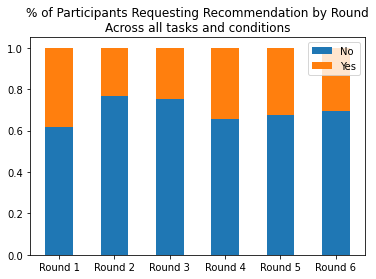

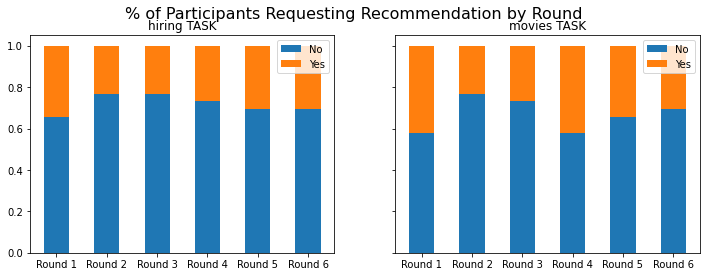

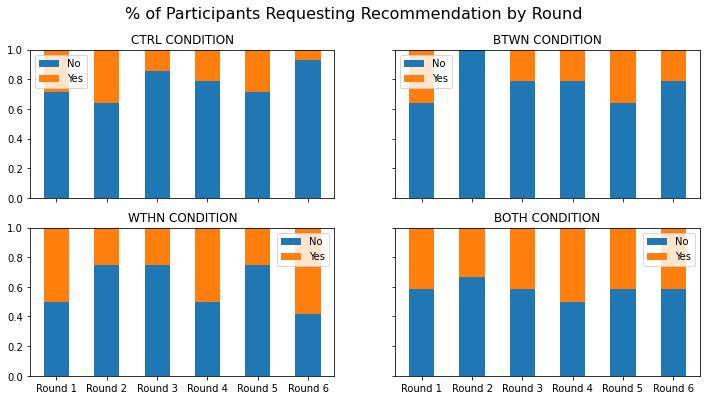

In [3]:
rows = []
task_columns = [f"Round {i+1}" for i in range(6)]

for task in TASKS:
    for condition in CONDITIONS:
        PIDS = ALL_PIDS[condition]
        for pid in PIDS:
            basepath = os.path.join(condition, pid)  # basepath for PID
            df = pd.read_csv(os.path.join(basepath, 'selections.csv'))

            ### NUMBER OF TIMES RECOMMENDATION WAS USED BEFORE SUBMISSION ###
            mask = (df["appMode"] == task)
            selections = df[mask]['recommendationShown'].replace({True: "# Yes", False: "# No"}).tolist()

            # Add to list of rows to create DataFrame from
            rows.append([pid, task, condition, *selections])

# Combine rows
df_get_rec = pd.DataFrame(
    rows,
    columns=['PID', 'Task', 'Condition', *task_columns]
)


### ALL TASKS/CONDITIONS ###

all_counts = pd.crosstab(**df_get_rec[task_columns].melt(var_name='columns', value_name='index'))
total = all_counts.sum(axis=0)
all_counts.loc['% No',:] = all_counts.loc['# No',:] / total
all_counts.loc['% Yes',:] = all_counts.loc['# Yes',:] / total
print("=== ALL TASKS/CONDITIONS ===")
print(all_counts)

# Plot
labels = list(all_counts.columns)
width = 0.5
fig, ax = plt.subplots()
ax.bar(labels, all_counts.loc['% No',:], width, label='No')
ax.bar(labels, all_counts.loc['% Yes',:], width, bottom=all_counts.loc['% No',:], label='Yes')
ax.set_title('% of Participants Requesting Recommendation by Round\nAcross all tasks and conditions')
ax.legend()

plt.savefig(f'charts/recs_by_round_all.png')



### BETWEEN TASKS ###

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

print()
col_num = 0
for task in TASKS:
    df_get_rec_task = df_get_rec[df_get_rec["Task"] == task]
    all_counts = pd.crosstab(**df_get_rec_task[task_columns].melt(var_name='columns', value_name='index'))
    total = all_counts.sum(axis=0)
    all_counts.loc['% No',:] = all_counts.loc['# No',:] / total
    all_counts.loc['% Yes',:] = all_counts.loc['# Yes',:] / total
    print()
    print(f"=== {task} TASK ===")
    print(all_counts)
    
    # Plot
    labels = list(all_counts.columns)
    width = 0.5
    ax = axes[col_num]
    ax.bar(labels, all_counts.loc['% No',:], width, label='No')
    ax.bar(labels, all_counts.loc['% Yes',:], width, bottom=all_counts.loc['% No',:], label='Yes')
    ax.set_title(f'{task} TASK')
    ax.legend()
    fig.suptitle('% of Participants Requesting Recommendation by Round', fontsize=16)
    
    col_num += 1

plt.savefig(f'charts/recs_by_round_task.png')


### BETWEEN CONDITIONS ###

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)

print()
row_num = 0
col_num = 0
for condition in CONDITIONS:
    df_get_rec_cond = df_get_rec[df_get_rec["Condition"] == condition]
    all_counts = pd.crosstab(**df_get_rec_cond[task_columns].melt(var_name='columns', value_name='index'))
    total = all_counts.sum(axis=0)
    all_counts.loc['% No',:] = all_counts.loc['# No',:] / total
    all_counts.loc['% Yes',:] = all_counts.loc['# Yes',:] / total
    print()
    print(f"=== {condition} CONDITION ===")
    print(all_counts)
    
    # Plot
    labels = list(all_counts.columns)
    width = 0.5
    ax = axes[row_num % 2][col_num // 2]
    ax.bar(labels, all_counts.loc['% No',:], width, label='No')
    ax.bar(labels, all_counts.loc['% Yes',:], width, bottom=all_counts.loc['% No',:], label='Yes')
    ax.set_title(f'{condition} CONDITION')
    ax.legend()
    fig.suptitle('% of Participants Requesting Recommendation by Round', fontsize=16)
    
    row_num += 1
    col_num += 1

plt.savefig(f'charts/recs_by_round_condition.png')

# Trajectory of matching bot choice across tasks/conditions

=== ALL TASKS/CONDITIONS ===
columns       Round 1    Round 2    Round 3    Round 4    Round 5    Round 6
index                                                                       
# Matching  38.000000  12.000000   8.000000   9.000000  27.000000  28.000000
# Not       14.000000  40.000000  44.000000  43.000000  25.000000  24.000000
% Not        0.269231   0.769231   0.846154   0.826923   0.480769   0.461538
% Matching   0.730769   0.230769   0.153846   0.173077   0.519231   0.538462


=== hiring TASK ===
columns       Round 1    Round 2    Round 3    Round 4    Round 5    Round 6
index                                                                       
# Matching  17.000000   4.000000   6.000000   5.000000  14.000000  20.000000
# Not        9.000000  22.000000  20.000000  21.000000  12.000000   6.000000
% Not        0.346154   0.846154   0.769231   0.807692   0.461538   0.230769
% Matching   0.653846   0.153846   0.230769   0.192308   0.538462   0.769231

=== movies TASK ===
colu

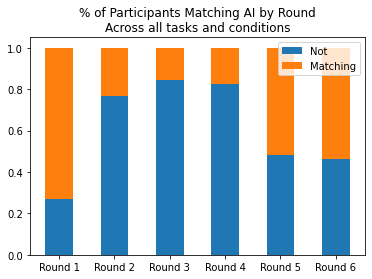

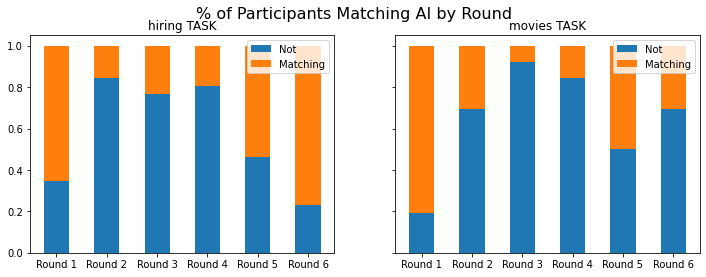

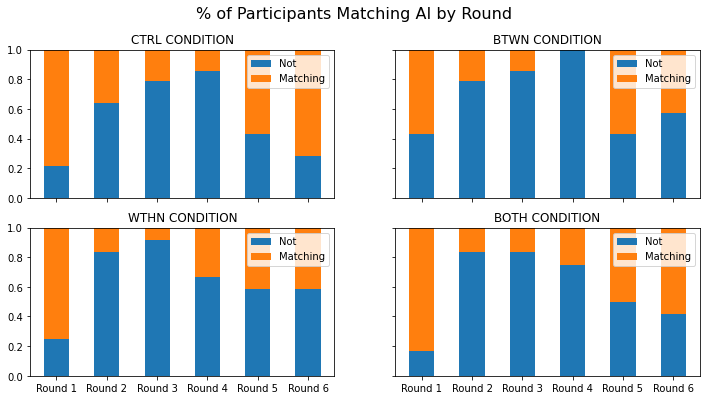

In [4]:
rows = []
task_columns = [f"Round {i+1}" for i in range(6)]

for task in TASKS:
    for condition in CONDITIONS:
        PIDS = ALL_PIDS[condition]
        for pid in PIDS:
            basepath = os.path.join(condition, pid)  # basepath for PID
            df = pd.read_csv(os.path.join(basepath, 'selections.csv'))

            ### NUMBER OF TIMES RECOMMENDATION WAS USED BEFORE SUBMISSION ###
            mask = (df["appMode"] == task)
            matching = (
                df[mask].apply(lambda x: x["selectedId"] == x["botChoice"], axis=1)
                    .replace({True: "# Matching", False: "# Not"})
                    .tolist()
            )
            # Add to list of rows to create DataFrame from
            rows.append([pid, task, condition, *matching])

# Combine rows
df_get_rec = pd.DataFrame(
    rows,
    columns=['PID', 'Task', 'Condition', *task_columns]
)


### ALL TASKS/CONDITIONS ###

all_counts = pd.crosstab(**df_get_rec[task_columns].melt(var_name='columns', value_name='index'))
total = all_counts.sum(axis=0)
all_counts.loc['% Not',:] = all_counts.loc['# Not',:] / total
all_counts.loc['% Matching',:] = all_counts.loc['# Matching',:] / total
print("=== ALL TASKS/CONDITIONS ===")
print(all_counts)

# Plot
labels = list(all_counts.columns)
width = 0.5
fig, ax = plt.subplots()
ax.bar(labels, all_counts.loc['% Not',:], width, label='Not')
ax.bar(labels, all_counts.loc['% Matching',:], width, bottom=all_counts.loc['% Not',:], label='Matching')
ax.set_title('% of Participants Matching AI by Round\nAcross all tasks and conditions')
ax.legend()

plt.savefig(f'charts/matches_by_round_all.png')



### BETWEEN TASKS ###

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

print()
col_num = 0
for task in TASKS:
    df_get_rec_task = df_get_rec[df_get_rec["Task"] == task]
    all_counts = pd.crosstab(**df_get_rec_task[task_columns].melt(var_name='columns', value_name='index'))
    total = all_counts.sum(axis=0)
    all_counts.loc['% Not',:] = all_counts.loc['# Not',:] / total
    all_counts.loc['% Matching',:] = all_counts.loc['# Matching',:] / total
    print()
    print(f"=== {task} TASK ===")
    print(all_counts)
    
    # Plot
    labels = list(all_counts.columns)
    width = 0.5
    ax = axes[col_num]
    ax.bar(labels, all_counts.loc['% Not',:], width, label='Not')
    ax.bar(labels, all_counts.loc['% Matching',:], width, bottom=all_counts.loc['% Not',:], label='Matching')
    ax.set_title(f'{task} TASK')
    ax.legend()
    fig.suptitle('% of Participants Matching AI by Round', fontsize=16)
    
    col_num += 1

plt.savefig(f'charts/matches_by_round_task.png')


### BETWEEN CONDITIONS ###

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)

print()
row_num = 0
col_num = 0
for condition in CONDITIONS:
    df_get_rec_cond = df_get_rec[df_get_rec["Condition"] == condition]
    all_counts = pd.crosstab(**df_get_rec_cond[task_columns].melt(var_name='columns', value_name='index'))
    total = all_counts.sum(axis=0)
    all_counts.loc['% Not',:] = all_counts.loc['# Not',:] / total
    all_counts.loc['% Matching',:] = all_counts.loc['# Matching',:] / total
    print()
    print(f"=== {condition} CONDITION ===")
    print(all_counts)
    
    # Plot
    labels = list(all_counts.columns)
    width = 0.5
    ax = axes[row_num % 2][col_num // 2]
    ax.bar(labels, all_counts.loc['% Not',:], width, label='Not')
    ax.bar(labels, all_counts.loc['% Matching',:], width, bottom=all_counts.loc['% Not',:], label='Matching')
    ax.set_title(f'{condition} CONDITION')
    ax.legend()
    fig.suptitle('% of Participants Matching AI by Round', fontsize=16)
    
    row_num += 1
    col_num += 1

plt.savefig(f'charts/matches_by_round_condition.png')

# Number of recommendations requested before submission between conditions - ANOVA

In [5]:
print("Number of recommendations requested before submission between conditions")
print("========================================================================")
print()

rows = []

for task in TASKS:
    for condition in CONDITIONS:
        PIDS = ALL_PIDS[condition]
        for pid in PIDS:
            basepath = os.path.join(condition, pid)  # basepath for PID
            df = pd.read_csv(os.path.join(basepath, 'interactions.csv'))

            ### NUMBER OF TIMES RECOMMENDATION WAS USED BEFORE SUBMISSION ###
            mask = (df["interactionType"] == "get_recommendation") & (df["appMode"] == task)
            get_rec_count = len(df[mask].index)

            # Add to list of rows to create DataFrame from
            rows.append([pid, task, condition, get_rec_count])

# Combine rows
df_get_rec = pd.DataFrame(
    rows,
    columns=['PID', 'Task', 'Condition', '# Recommendations']
)



### BETWEEN ALL CONDITIONS ###

print('Between conditions | across tasks')
print('---------------------------------')

# Show 5 number summary
print(df_get_rec.groupby('Condition')['# Recommendations'].describe())
print()

# Perform ANOVA 1-way test
vals = df_get_rec.groupby('Condition')['# Recommendations'].apply(list).tolist()
f_stat, p_val = f_oneway(*vals)
print(f"One-Way ANOVA\t|\tGroups: Condition\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()



### BETWEEN CONTROL AND INTERVENTION ###

print('Between CTRL (CONTROL) and WTHN + BTWN + BOTH (INTERVENTION) | across tasks')
print('---------------------------------------------------------------------------')

# Show 5 number summary
print(
    df_get_rec.replace(['WTHN', 'BTWN', 'BOTH'], 'INTV')
        .groupby('Condition')['# Recommendations']
        .describe()
)
print()

# Perform ANOVA 1-way test
vals = df_get_rec.replace(['WTHN', 'BTWN', 'BOTH'], 'INTV').groupby('Condition')['# Recommendations'].apply(list).tolist()
f_stat, p_val = f_oneway(*vals)
print(f"One-Way ANOVA\t|\tGroups: Condition\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()



### BETWEEN TASKS ###

print('Between tasks | across conditions')
print('---------------------------------')

# Show 5 number summary
print(df_get_rec.groupby('Task')['# Recommendations'].describe())
print()

# Perform ANOVA 1-way test
vals = df_get_rec.groupby('Task')['# Recommendations'].apply(list).tolist()
f_stat, p_val = f_oneway(*vals)
print(f"One-Way ANOVA\t|\tGroups: Condition\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()


Number of recommendations requested before submission between conditions

Between conditions | across tasks
---------------------------------
           count      mean       std  min  25%  50%   75%  max
Condition                                                     
BOTH        12.0  2.500000  2.713602  0.0  0.0  1.0  6.00  6.0
BTWN        14.0  1.357143  1.499084  0.0  0.0  1.0  2.75  4.0
CTRL        14.0  1.357143  1.645841  0.0  0.0  1.0  2.00  6.0
WTHN        12.0  2.333333  2.269695  0.0  0.0  2.0  4.00  6.0

One-Way ANOVA	|	Groups: Condition	|	F Statistic: 1.1617	|	p-value: 0.3341

Between CTRL (CONTROL) and WTHN + BTWN + BOTH (INTERVENTION) | across tasks
---------------------------------------------------------------------------
           count      mean       std  min  25%  50%  75%  max
Condition                                                    
CTRL        14.0  1.357143  1.645841  0.0  0.0  1.0  2.0  6.0
INTV        38.0  2.026316  2.187024  0.0  0.0  1.5  3.0  6.0

One

# Number of recommendations requested before submission between participant working knowledge - ANOVA

In [6]:
print("Number of recommendations requested before submission between participant working knowledge")
print("===========================================================================================")
print()

# get participant working knowledge bool
df_ai_knowledge = pd.read_csv(os.path.join("qualtrics", "understand_ai_concepts.csv"), index_col=0)

rows = []

for task in TASKS:
    for condition in CONDITIONS:
        PIDS = ALL_PIDS[condition]
        for pid in PIDS:
            basepath = os.path.join(condition, pid)  # basepath for PID
            df = pd.read_csv(os.path.join(basepath, 'interactions.csv'))

            ### NUMBER OF TIMES RECOMMENDATION WAS USED BEFORE SUBMISSION ###
            mask = (df["interactionType"] == "get_recommendation") & (df["appMode"] == task)
            get_rec_count = len(df[mask].index)
            
            working_knowledge = df_ai_knowledge.at[pid, "DO_YOU_UNDERSTAND_AI"]

            # Add to list of rows to create DataFrame from
            rows.append([pid, task, condition, get_rec_count, working_knowledge])

# Combine rows
df_get_rec = pd.DataFrame(
    rows,
    columns=['PID', 'Task', 'Condition', '# Recommendations', 'Working Knowledge?']
)



### BETWEEN ALL CONDITIONS ###

print('Between working knowledge | across tasks/conditions')
print('---------------------------------------------------')

# Show 5 number summary
print(df_get_rec.groupby('Working Knowledge?')['# Recommendations'].describe())
print()

# Perform ANOVA 1-way test
vals = df_get_rec.groupby('Working Knowledge?')['# Recommendations'].apply(list).tolist()
f_stat, p_val = f_oneway(*vals)
print(f"One-Way ANOVA\t|\tGroups: Condition\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()

Number of recommendations requested before submission between participant working knowledge

Between working knowledge | across tasks/conditions
---------------------------------------------------
                    count      mean       std  min  25%  50%   75%  max
Working Knowledge?                                                     
no                   24.0  1.708333  2.176538  0.0  0.0  1.0  2.25  6.0
yes                  28.0  1.964286  1.990387  0.0  0.0  2.0  3.00  6.0

One-Way ANOVA	|	Groups: Condition	|	F Statistic: 0.1960	|	p-value: 0.6598



# Usefulness and Frequency scores - ANOVA

CTRL    2.714286
WTHN    3.000000
BTWN    2.142857
BOTH    2.166667
dtype: float64
HIRING_AI_RECOMMENDATIONS_USEFUL|	One-Way ANOVA	|	F Statistic: 0.8515	|	p-value: 0.4807

CTRL    2.285714
WTHN    1.666667
BTWN    1.571429
BOTH    1.833333
dtype: float64
HIRING_AI_RECOMMENDATIONS_FREQ	|	One-Way ANOVA	|	F Statistic: 0.4568	|	p-value: 0.7152

CTRL         NaN
WTHN    1.666667
BTWN    2.000000
BOTH    1.666667
dtype: float64
HIRING_AI_REVIEWS_USEFUL	|	One-Way ANOVA	|	F Statistic: 0.2679	|	p-value: 0.7683

CTRL    3.142857
WTHN    2.500000
BTWN    2.714286
BOTH    2.333333
dtype: float64
MOVIES_AI_RECOMMENDATIONS_USEFUL|	One-Way ANOVA	|	F Statistic: 0.5357	|	p-value: 0.6627

CTRL    3.000000
WTHN    1.666667
BTWN    2.428571
BOTH    2.166667
dtype: float64
MOVIES_AI_RECOMMENDATIONS_FREQ	|	One-Way ANOVA	|	F Statistic: 1.2270	|	p-value: 0.3235

CTRL         NaN
WTHN    2.000000
BTWN    2.428571
BOTH    1.666667
dtype: float64
MOVIES_AI_REVIEWS_USEFUL	|	One-Way ANOVA	|	F Statistic: 0.5619	|	p

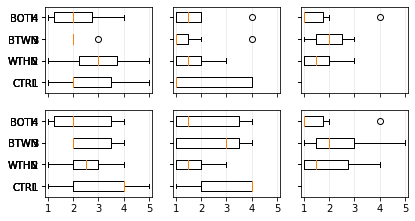

In [7]:
df_useful = pd.read_csv(os.path.join("qualtrics", "useful_freq_likert.csv"))
grouped = df_useful.groupby("CONDITION")
labels = ["CTRL", "WTHN", "BTWN", "BOTH"]

### PLOT ###
fig, axes = plt.subplots(2, 3, figsize=(6.5, 3.5), sharex=True, sharey=True)


### (1, 1) ###
data = [
    grouped.get_group("CTRL")["HIRING_AI_RECOMMENDATIONS_USEFUL"].tolist(),
    grouped.get_group("WTHN")["HIRING_AI_RECOMMENDATIONS_USEFUL"].tolist(),
    grouped.get_group("BTWN")["HIRING_AI_RECOMMENDATIONS_USEFUL"].tolist(),
    grouped.get_group("BOTH")["HIRING_AI_RECOMMENDATIONS_USEFUL"].tolist(),
]
print(pd.DataFrame(data, index=labels).T.mean())
f_stat, p_val = f_oneway(*data)
print(f"HIRING_AI_RECOMMENDATIONS_USEFUL|\tOne-Way ANOVA\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()
ax_curr = axes[0][0]
bp = ax_curr.boxplot(data, vert=False, labels=labels)
ax_curr.set_xlim(0.9, 5.1)
ax_curr.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)


### (1, 2) ###
data = [
    grouped.get_group("CTRL")["HIRING_AI_RECOMMENDATIONS_FREQ"].tolist(),
    grouped.get_group("WTHN")["HIRING_AI_RECOMMENDATIONS_FREQ"].tolist(),
    grouped.get_group("BTWN")["HIRING_AI_RECOMMENDATIONS_FREQ"].tolist(),
    grouped.get_group("BOTH")["HIRING_AI_RECOMMENDATIONS_FREQ"].tolist(),
]
print(pd.DataFrame(data, index=labels).T.mean())
f_stat, p_val = f_oneway(*data)
print(f"HIRING_AI_RECOMMENDATIONS_FREQ\t|\tOne-Way ANOVA\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()
ax_curr = axes[0][1]
bp = ax_curr.boxplot(data, vert=False, labels=labels)
ax_curr.set_xlim(0.9, 5.1)
ax_curr.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)


### (1, 3) ###
data = [
    grouped.get_group("CTRL")["HIRING_AI_REVIEWS_USEFUL"].tolist(),
    grouped.get_group("WTHN")["HIRING_AI_REVIEWS_USEFUL"].tolist(),
    grouped.get_group("BTWN")["HIRING_AI_REVIEWS_USEFUL"].tolist(),
    grouped.get_group("BOTH")["HIRING_AI_REVIEWS_USEFUL"].tolist(),
]
print(pd.DataFrame(data, index=labels).T.mean())
f_stat, p_val = f_oneway(*data[1:])  # don't use CTRL data (all NaN's)
print(f"HIRING_AI_REVIEWS_USEFUL\t|\tOne-Way ANOVA\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()
ax_curr = axes[0][2]
bp = ax_curr.boxplot(data, vert=False)
ax_curr.set_xlim(0.9, 5.1)
ax_curr.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)


### (2, 1) ###
data = [
    grouped.get_group("CTRL")["MOVIES_AI_RECOMMENDATIONS_USEFUL"].tolist(),
    grouped.get_group("WTHN")["MOVIES_AI_RECOMMENDATIONS_USEFUL"].tolist(),
    grouped.get_group("BTWN")["MOVIES_AI_RECOMMENDATIONS_USEFUL"].tolist(),
    grouped.get_group("BOTH")["MOVIES_AI_RECOMMENDATIONS_USEFUL"].tolist(),
]
print(pd.DataFrame(data, index=labels).T.mean())
f_stat, p_val = f_oneway(*data)
print(f"MOVIES_AI_RECOMMENDATIONS_USEFUL|\tOne-Way ANOVA\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()
ax_curr = axes[1][0]
bp = ax_curr.boxplot(data, vert=False, labels=labels)
ax_curr.set_xlim(0.9, 5.1)
ax_curr.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)


### (2, 2) ###
data = [
    grouped.get_group("CTRL")["MOVIES_AI_RECOMMENDATIONS_FREQ"].tolist(),
    grouped.get_group("WTHN")["MOVIES_AI_RECOMMENDATIONS_FREQ"].tolist(),
    grouped.get_group("BTWN")["MOVIES_AI_RECOMMENDATIONS_FREQ"].tolist(),
    grouped.get_group("BOTH")["MOVIES_AI_RECOMMENDATIONS_FREQ"].tolist(),
]
print(pd.DataFrame(data, index=labels).T.mean())
f_stat, p_val = f_oneway(*data)
print(f"MOVIES_AI_RECOMMENDATIONS_FREQ\t|\tOne-Way ANOVA\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()
ax_curr = axes[1][1]
bp = ax_curr.boxplot(data, vert=False, labels=labels)
ax_curr.set_xlim(0.9, 5.1)
ax_curr.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)


### (2, 3) ###
data = [
    grouped.get_group("CTRL")["MOVIES_AI_REVIEWS_USEFUL"].tolist(),
    grouped.get_group("WTHN")["MOVIES_AI_REVIEWS_USEFUL"].tolist(),
    grouped.get_group("BTWN")["MOVIES_AI_REVIEWS_USEFUL"].tolist(),
    grouped.get_group("BOTH")["MOVIES_AI_REVIEWS_USEFUL"].tolist(),
]
print(pd.DataFrame(data, index=labels).T.mean())
f_stat, p_val = f_oneway(*data[1:])  # don't use CTRL data (all NaN's)
print(f"MOVIES_AI_REVIEWS_USEFUL\t|\tOne-Way ANOVA\t|\tF Statistic: {f_stat:.04f}\t|\tp-value: {p_val:.04f}")
print()
ax_curr = axes[1][2]
bp = ax_curr.boxplot(data, vert=False)
ax_curr.set_xlim(0.9, 5.1)
ax_curr.xaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)


### ENTIRE PLOT ###

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks([1,2,3,4,5])

plt.savefig('charts/likert_raw.png')